In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,ElasticNetCV

from sklearn.model_selection import GridSearchCV

In [2]:
mtcars = sm.datasets.get_rdataset("mtcars")['data']

# 설명변수, 종속변수 설정
y = mtcars[['mpg']]
x = mtcars[mtcars.columns[1:]]

# centering y & standardizing x
yc = y-y.mean()
xs = (x-x.mean())/x.std()

# lambda 범위 설정
lambda_to_try = 10**np.linspace(-3, 5, 100)

In [3]:
# GridSearchCV 사용
ridge = Ridge()
param = {'alpha': lambda_to_try}
ridge_regressor = GridSearchCV(ridge, param, scoring='neg_mean_squared_error', cv=10)
ridge_regressor.fit(xs, yc)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-03, 1.20450354e-03, 1.45082878e-03, 1.74752840e-03,
       2.10490414e-03, 2.53536449e-03, 3.05385551e-03, 3.67837977e-03,
       4.4306214...
       2.91505306e+03, 3.51119173e+03, 4.22924287e+03, 5.09413801e+03,
       6.13590727e+03, 7.39072203e+03, 8.90215085e+03, 1.07226722e+04,
       1.29154967e+04, 1.55567614e+04, 1.87381742e+04, 2.25701972e+04,
       2.71858824e+04, 3.27454916e+04, 3.94420606e+04, 4.75081016e+04,
       5.72236766e+04, 6.89261210e+04, 8.30217568e+04, 1.00000000e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

### R에서 plot(ridge_cv) plot과 유사한 자료를 찾기 위해 ridge_regressor.cv_results_ 라는 사전형 자료를 탐색한 코드

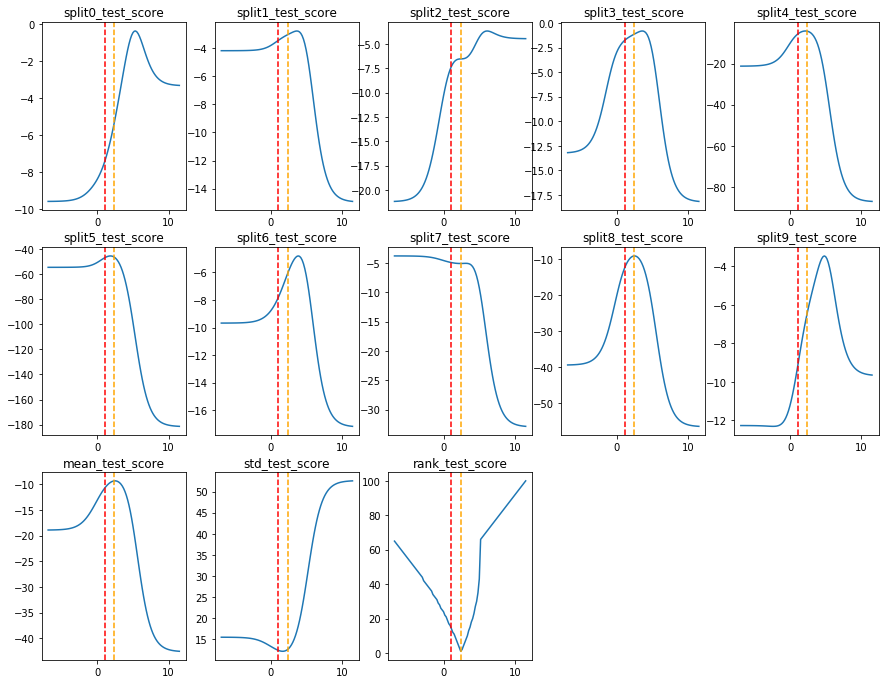

In [4]:
ridge_dict = ridge_regressor.cv_results_

i = 1
fig = plt.figure(figsize=(15,20))
for k in ridge_dict.keys():
    if 'param' not in k and 'time' not in k:
        fig.add_subplot(5,5,i)
        plt.plot(np.log(lambda_to_try), ridge_dict[k])
        plt.axvline(np.log(2.984), color='red', ls='--')
        plt.axvline(np.log(10.975), color='orange', ls='--')
        plt.title(k)
#         plt.show()
        i += 1

### 위 plot 결과에서 std_test_score의 경우가 강의 자료(R)의 ridge regression plot결과와 유사함을 발견
#### 그리하여 하단과 같은 코드 실행

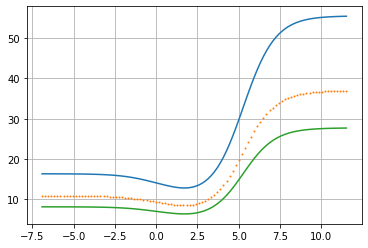

In [5]:
a = pd.DataFrame([ridge_dict[f'split{i}_test_score'] for i in range(10)]).T
a.index = np.log(lambda_to_try)

b = pd.DataFrame(a.std(axis=1))
b.index = np.log(lambda_to_try)
plt.plot(b)
plt.plot(b/1.5, marker='o', ls=' ', ms=1)
plt.plot(b/2)
# plt.scatter(b.sort_values(0).head(1).index, b.sort_values(0).head(1)[0], color='red', s=5) #최소인점
plt.grid()

### MSE를 계산해보고자 하단과 같은 코드 실행
#### 그러나 강의자료 plot(ridge_cv)의 y축에 나타난 MSE와는 개념이 다른 것임을 발견하여 이용하지 않음

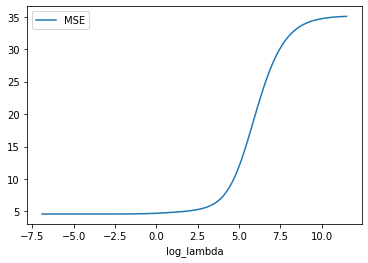

In [6]:
# Ridge를 쓰고 for loop
ridge = Ridge()

MSE = []
coefs = []
costs = []
for Lambda in lambda_to_try:
    ridge.set_params(alpha=Lambda).fit(xs, yc)
    yhat = ridge.predict(xs)
    mse = ((yc-yhat)**2).sum()[0]/32
    MSE.append(mse)
    coef = ridge.coef_
    coefs.append(coef)
    
MSE = pd.DataFrame(MSE, np.log(lambda_to_try))
MSE.index.name = 'log_lambda'
MSE.columns = ['MSE']

MSE.plot()
plt.show()

### R에서의 glmnet과 파이썬의 Ridge, RidgeCV, GridSearchCV을 이용한 회귀계수 추정치가 다름을 확인
### 패키지를 이용하지 않고 raw한 상황에서 rough하게 코드작업 후 패키지의 Ridge 함수와의 비교
$\hat{\beta}$ = $(X^TX + \lambda I)^{-1}X^TY$ 수식 이용

In [9]:
# 기존 독립변수에 상수항을 적합하기 위한 코드
ones = pd.DataFrame(np.ones((xs.shape[0], 1)), index=xs.index, columns=['intercept'])
xs2 = pd.concat([ones, xs.copy()], axis=1) 

In [10]:
SSEs = {}
weights = pd.DataFrame(columns=['intercept']+list(xs.columns)) # lambda 값에 따른 weight 저장(intercept 포함)
yhats = {}

for Lambda in lambda_to_try:
    Unit = np.eye(xs2.shape[1]) # identity matrix 생성
    weight = np.linalg.inv(xs2.T.dot(xs2)+Lambda*Unit).dot(xs2.T).dot(yc) # 회귀계수 추정치 계산을 위한 행렬수식 코드
    weights.loc[np.round(Lambda, 6), :] = np.round(weight.T, 5)
    weight = pd.DataFrame(weight, index=xs2.columns, columns=['weight'])
    
    yhat = xs2.dot(weight).rename(columns={'weight': yc.columns[0]})
    yhats[round(Lambda, 6)] = yhat
    error = yhat-yc
    SSE = error.T.dot(error) + (weight**2).sum().rename(index={'weight': yc.columns[0]})*Lambda
    SSEs[round(Lambda, 6)] = SSE.iloc[0,0]

### 이하 코드로 확인한 결과 군데군데 False가 존재하지만 이는 반올림 과정에서 생긴 미세한 오차로 판단됨
### 즉 파이썬 sklearn 패키지의 Ridge 함수는 행렬수식에 따라 회귀계수 추정치를 계산하는 것으로 확신함
### R의 glmnet 함수 내부 구조를 오랜 시간 연구해 보았지만 어떠한 구조로 회귀계수를 추정하는지는 확인하는 데에 실패하였음

In [11]:
for Lambda in weights.index:
    raw_compute = np.array(weights.loc[Lambda][1:])  # 위의 계산을 이용한 회귀계수 추정
    
    ridge = Ridge(alpha=Lambda)
    ridge.fit(xs, yc)
    pack_compute = np.round(ridge.coef_, 5) # 패키지 함수를 이용한 회귀계수 추정
    pack_compute = pack_compute.reshape(raw_compute.shape) # 비교를 위해 차원 축소
    
    print(raw_compute == pack_compute) # 동일한 결과인지 확인

[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True False  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  

#### 이하는 R의 lm function도 glmnet처럼 행렬수식과는 다른 방식으로 계산하는지 검증해본 코드입니다.
#### 임의의 데이터를 활용하였고, multiple regression의 회귀계수 추정치를 계산하는 행렬수식에 따라 계산한 코드입니다.
#### R에서 확인한 결과 OLS의 경우에는 이하 결과와 동일한 회귀계수 추정치를 계산해냈음을 확인했습니다.
$\hat{\beta}$ = $(X^TX)^{-1}X^TY$ 수식 이용

In [12]:
# 데이터 구축
x = '0.05066461  0.14903066  0.94871790  1.20506737  0.62847387  0.34908599 -0.08514611 -1.45107402 -1.09948585  0.87170731 0.54635235  0.09920640 -1.15224546 -0.48753925 -1.81363920 -0.70407507  0.10026963  0.55446424  0.07576445 -1.36494910'
x = 10*np.round(np.array(x.split(), dtype='float64'), 3).reshape(2, 10).T
x = pd.DataFrame(x, columns=['indep1', 'indep2'], index=[f'x{k}' for k in range(1, 11)])
x = pd.concat([pd.DataFrame(np.ones((x.shape[0], 1)), columns=['intercept'], index=x.index), x], axis=1)

y = '-0.6468287 -0.4291190 -0.5011876  0.3688860  0.1422105 -0.7040640  1.0966151  0.5360112 -0.9885035  1.0062910'
y = 10*np.round(np.array(y.split(), dtype='float64'), 3).reshape(1, 10).T
y = pd.DataFrame(y, columns=['dep'], index=[f'x{k}' for k in range(1, 11)])

In [13]:
# multiple regression (OLS)
# beta hat 추정
beta_hat = pd.DataFrame(np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y), columns=['weight'], index=['intercept']+[f'indep{k}' for k in [1,2]])
prediction = x.dot(beta_hat)
beta_hat

,weight
intercept,-0.610632
indep1,0.059545
indep2,-0.095773


In [14]:
x

,intercept,indep1,indep2
x1,1.0,0.51,5.46
x2,1.0,1.49,0.99
x3,1.0,9.49,-11.52
x4,1.0,12.05,-4.88
x5,1.0,6.28,-18.14
x6,1.0,3.49,-7.04
x7,1.0,-0.85,1.00
x8,1.0,-14.51,5.54
x9,1.0,-10.99,0.76
x10,1.0,8.72,-13.65


In [15]:
# 재미삼아 ridge regression도 확인
x2 = x.iloc[:, 1:3] # x의 상수항 제거
xs = (x2 - x2.mean())/x2.std() # standardizing x
xs = pd.concat([pd.DataFrame(np.ones((xs.shape[0], 1)), columns=['intercept'], index=xs.index), xs], axis=1) # 상수항 적합
yc = y - y.mean() # centering y

Lambda = 0.5 # set lambda
unit = np.eye(xs.shape[1]) # identity matrix

beta_hat = np.linalg.inv(xs.T.dot(xs)+Lambda*unit).dot(xs.T).dot(yc)

beta_hat

array([[ 6.66133815e-16],
       [ 5.15329194e-01],
       [-7.48172045e-01]])

In [16]:
ridge = Ridge(alpha=0.5)
ridge.fit(xs, yc)
ridge.coef_

array([[ 0.        ,  0.51532919, -0.74817205]])

#### 잘 나오는 것을 확인